self.numpoints 300
unique stages: [0 1]
{'not_infected': 0.3, 'infected': 0.65, 'contagious': 0.7, 'diagnosed': 0.8, 'immobilized': 0.9, 'recovered': 0.4}
5


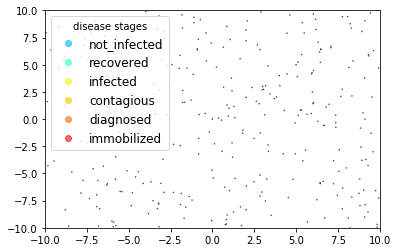

In [15]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from transition_manager import TransitionManager
from IPython.display import HTML

amount_of_movement = 0.15
radius_of_possible_infection = 1
probability_of_getting_infected = 0.1
size_of_box = 20
numpoints = 300
recovered_cant_infect = True

INITIAL_NUM_INFECTED = 5
SIZE = 0.2

def get_status_colors():
    """creates and returns a dict with the colors for the different statuses of the balls
    
    Returns:
        [dict] -- a dict for the status colors of the balls:
                    keys are: [not_infected, infected, contagious, sick-immobilized, immune]
    """
    colors = {
        "not_infected" : 0.3,
        "infected" : 0.65,
        "contagious" : 0.7,
        "diagnosed": 0.8,
        "immobilized" : 0.9,
        "recovered" : 0.4,
    }
    return colors


def get_status2num_dict():
    """[summary]
    
    Returns:
        [type] -- [description]
    """

    status2num = {
        "not_infected" : 0,
        "infected" : 1,
        "contagious" : 2,
        "diagnosed": 3,
        "immobilized" : 4,
        "recovered" : 5,
    }
    return status2num


def get_num2status_dict():
    """[summary]
    
    Returns:
        [type] -- [description]
    """
    status2num = get_status2num_dict()
    num2status = {}
    for key, val in status2num.items():
        num2status[val] = key

    return num2status


def get_movement_coefficient():
    """"samples the movement coefficient from a boltzman distribution
    how much each individual moves
    
    """


class CoronaSimulator(object):
    """An animated scatter plot using matplotlib.animations.FuncAnimation."""
    def __init__(self, numpoints=100, num_infected=5, max_num_steps=500, recovered_cant_infect=True, 
                amount_of_movement=0.15, radius_of_possible_infection=1, 
                probability_of_getting_infected=0.1, size_of_box=20):

        self.numpoints = numpoints
        self.recovered_cant_infect = recovered_cant_infect
        self.stream = self.data_stream()
        self.amount_of_movement = amount_of_movement
        self.radius_of_possible_infection = radius_of_possible_infection
        self.probability_of_getting_infected = probability_of_getting_infected
        self.size_of_box = size_of_box
        # Setup the figure and axes...
        self.fig, self.ax = plt.subplots()
        # Then setup FuncAnimation.
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=5, 
                                          init_func=self.setup_plot, blit=True)
        self.status_colors = get_status_colors()
        print(self.status_colors)
        self.num_infected = num_infected
        print(self.num_infected)
        self.status2num = get_status2num_dict()
        self.initialize_infected(num_infected)
        self.counter = 0
        self.max_num_steps = max_num_steps
        self.transition_manager = TransitionManager(numpoints)


    def setup_plot(self):
        """Initial drawing of the scatter plot."""
        x, y, s, c = next(self.stream).T
        self.scat = self.ax.scatter(x, y, c=c, s=s, vmin=0, vmax=1,
                                    cmap="jet", edgecolor="k", alpha=0.9)
        L = int(self.size_of_box/2)
        self.ax.axis([-L, L, -L, L])

        # add legend
        self.handles, self.labels = self.get_handles_for_legend()
        self.ax.legend(self.handles, self.labels, loc="upper left", title="disease stages", fontsize=12)
        self.ax.set_zorder(-1)

        # For FuncAnimation's sake, we need to return the artist we'll be using
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,


    def get_handles_for_legend(self):

        colors = np.zeros(len(self.status2num))
        x, y = np.arange(len(self.status2num)), np.arange(len(self.status2num))

        color_names = [None]*len(self.status2num)
        for status, num in self.status2num.items():
            colors[num] = self.status_colors[status]
            color_names[num] = status


        scat = plt.scatter(x, y, c=colors, s=SIZE*np.ones(len(self.status2num)), vmin=0, vmax=1, label=list(color_names),
                                    cmap="jet", edgecolor="k")

        handles, labels =  scat.legend_elements(prop="colors", alpha=0.6)

        # fix the resorting issue created within the scat.legend_elements function - to reallign the handles and the labels
        handle_labels = []
        for i in range(len(labels)):
            handle_color = float(labels[i].split('{')[-1].split('}')[0])
            idx = np.argmin((handle_color - colors)**2)
            handle_labels.append(color_names[idx])

        return handles, handle_labels


    def data_stream(self):
        """Generate a random walk (brownian motion). Data is scaled to produce
        a soft "flickering" effect."""
        xy, sizes, colors = self.initialize_data_stream()

        while True:
            xy = self.update_positions(xy)
            self.update_status(xy)
            colors = self.update_colors()
            # self.counter += 1
            # if self.counter > self.max_num_steps:
            #     break
            
            yield np.c_[xy[:,0], xy[:,1], sizes, colors]

    def update_positions(self, xy):
        """[summary]
        
        Arguments:
            xy {[np.ndarray]} -- the xy positions of all the individuals
        
        Returns:
            [xy] -- [description]
        """
        try:
            self.current_stages_of_individuals = self.current_stages_of_individuals
        except AttributeError:
            self.current_stages_of_individuals = np.zeros(self.numpoints).astype("int")

        mobile_individuals = np.expand_dims((self.current_stages_of_individuals != 4).astype("int"),1)
        xy += self.amount_of_movement * mobile_individuals * (np.random.random((self.numpoints, 2)) - 0.5) 

        return xy


    def update_colors(self):
        """update the status colors according to the stages of the desease
        
        Returns:
            [np.ndarray] -- an array with the status colors of the different individuals
        """
        infected = np.zeros(self.numpoints)
        infected[self.identities_of_infected] = 1

        # self.stages_of_individuals = infected
        colors = np.zeros(self.numpoints)

        try:
            self.status2num = self.status2num
        except AttributeError:
            self.status2num = get_status2num_dict()
        for stage_name, stage_num in self.status2num.items():
            colors += self.status_colors[stage_name] * ( self.current_stages_of_individuals == stage_num )

        return colors


    def initialize_infected(self, num_infected):
        """ initializes the infected matrix with the number of infected individuals"""

        self.infected_matrix = np.zeros((self.numpoints,self.numpoints))
        self.current_stages_of_individuals = np.zeros(self.numpoints).astype("int")
        self.identities_of_infected = np.random.randint(0, self.numpoints, num_infected)

        # set the rows of the infected to 1
        self.infected_matrix[self.identities_of_infected, :] = 1
        self.current_stages_of_individuals[self.identities_of_infected] = 1


    def update_status(self, xy):

        # find all individuals that are within radius of infection
        x = np.expand_dims(xy[:,0] , 1)
        y = np.expand_dims(xy[:,1] , 1)
        adjacency_matrix = np.sqrt((x - x.T)**2 + (y - y.T)**2 )
        within_radius = (adjacency_matrix < self.radius_of_possible_infection)

        # find individuals that are within this radius with another infected individual
        try:
            self.infected_matrix = self.infected_matrix
        except AttributeError:
            self.identities_of_infected = np.random.randint(0, self.numpoints, INITIAL_NUM_INFECTED)
            self.infected_matrix = np.zeros((self.numpoints,self.numpoints))
            self.infected_matrix[self.identities_of_infected, :] = 1


        at_risk_of_infection = within_radius * self.infected_matrix

        # find all individuals that should probabalistically get infected  (with or without contact with another infected)
        should_get_infected = ( np.random.rand(self.numpoints, self.numpoints) < self.probability_of_getting_infected)

        # find newly infected that are within the infection radious
        newly_infected = should_get_infected * at_risk_of_infection

        # save the identities of the newly infected
        identities_of_newly_infected = np.nonzero( np.sum(newly_infected,0) ) [0]

        # update who is infected
        self.update_who_is_infected(identities_of_newly_infected)

        # update the different stages of the disease
        self.current_stages_of_individuals = self.transition_manager.update_stages_of_disease(self.current_stages_of_individuals)
        print(f"unique stages: {np.unique(self.current_stages_of_individuals)}")


    def update_who_is_infected(self, identities_of_newly_infected):

        # create helper vector to prevent overlaps
        already_infected, newly_infected = np.zeros(self.numpoints), np.zeros(self.numpoints)
        already_infected[self.identities_of_infected] = 1
        newly_infected[identities_of_newly_infected] = 1

        # update identities of infected
        updated_infected = np.logical_or(already_infected, newly_infected)
        self.identities_of_infected = np.nonzero(updated_infected)[0]
        if self.recovered_cant_infect:
            self.identities_of_recovered = np.nonzero(self.current_stages_of_individuals == 5)[0]
            self.identities_of_infected = np.array([idx for idx in self.identities_of_infected if idx not in self.identities_of_recovered ]).astype("int")
            updated_infected = np.zeros(self.numpoints)
            updated_infected[self.identities_of_infected] = 1



        # update infected matrix
        self.infected_matrix = np.zeros_like(self.infected_matrix)
        self.infected_matrix[self.identities_of_infected, :] = 1

        # update 
        new_cases = (updated_infected - already_infected).copy().astype("int")
        try:
            self.transition_manager.time_counters[np.nonzero(new_cases)[0]] = 0
        except AttributeError:
            self.transition_manager = TransitionManager(self.numpoints)
            self.transition_manager.time_counters[np.nonzero(new_cases)[0]] = 0
        self.current_stages_of_individuals += new_cases


    def initialize_data_stream(self):
        """initializes he sizes positions and sizes and statuses of the balls
        
        Returns:
            [np.ndarray, np.ndarray, np.ndarray] -- the positions, sizes and colors of the balls, in that corresponding order
        """
        xy = (np.random.random((self.numpoints, 2))-0.5)*self.size_of_box
        sizes = SIZE*np.ones(self.numpoints)
        print("self.numpoints",self.numpoints)
        self.status_colors = get_status_colors()
        colors = self.status_colors['not_infected']*np.ones(self.numpoints)

        return xy, sizes, colors 


    def update(self, i):
        """Update the scatter plot."""
        data = next(self.stream)

        # Set x and y data...
        self.scat.set_offsets(data[:, :2])
        # Set sizes...
        self.scat.set_sizes(300 * abs(data[:, 2])**1.5 + 100)
        # Set colors..
        self.scat.set_array(data[:, 3])
        
        # legend1 = self.ax.legend(self.handles, self.labels, loc="upper left", title="disease stages", fontsize=10)
        # self.ax.add_artist(legend1)
        # We need to return the updated artist for FuncAnimation to draw..
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,


if __name__ == '__main__':
    a = CoronaSimulator(
                        numpoints=numpoints, 
                        recovered_cant_infect=recovered_cant_infect, 
                        amount_of_movement=amount_of_movement,
                        radius_of_possible_infection=radius_of_possible_infection,
                        probability_of_getting_infected=probability_of_getting_infected,
                        size_of_box=size_of_box
        )
    HTML(plt.show())